#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.43311543,  0.89925267,  0.06128347],
       [-0.89599176,  0.43694464, -0.07923476],
       [-0.09802956, -0.02059168,  0.99497045]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000966


In [29]:
Ret

array([[[ 0.43311543,  0.89925267,  0.06128347],
        [-0.89599176,  0.43694464, -0.07923476],
        [-0.09802956, -0.02059168,  0.99497045]],

       [[-0.02604722,  0.00887139, -0.99962135],
        [ 0.54696068,  0.83713049, -0.00682288],
        [ 0.83675298, -0.54693129, -0.02665723]],

       [[-0.68197631, -0.32472778,  0.65533212],
        [ 0.30823247, -0.9401787 , -0.14510947],
        [ 0.66325037,  0.10303342,  0.74127124]],

       [[ 0.99928452, -0.03773407, -0.00256857],
        [-0.0238539 , -0.5760897 , -0.81703834],
        [ 0.02935046,  0.81651503, -0.57657762]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([1.20564808, 0.17217901, 2.14385606, 1.12881094])

In [34]:
C1(dx,dy,dz,Ret)

array([[-0.24892579,  0.23415478, -1.02884562,  1.0869391 ],
       [-1.5657516 ,  0.39091714,  1.25922257, -0.35882066],
       [ 0.91236613, -0.04247157,  1.58925569,  1.1614899 ]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000368


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[-1428.59357903,  1343.82224216, -5904.57994986,  6237.98036504],
       [-8985.90157763,  2243.48673796,  7226.72105045, -2059.28396492],
       [ 5236.10020066,  -243.74580206,  9120.79235213,  6665.82994231]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[-1428.59357903, -8985.90157763,  5236.10020066],
       [ 1343.82224216,  2243.48673796,  -243.74580206],
       [-5904.57994986,  7226.72105045,  9120.79235213],
       [ 6237.98036504, -2059.28396492,  6665.82994231]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000334


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000434


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000490


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.001552


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.001603


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000249


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000795


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        , 415397.80321504],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,  47504.96028091]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ 1428.59357903, -1343.82224216,  5904.57994986, -6237.98036504],
       [ 8985.90157763, -2243.48673796, -7226.72105045,  2059.28396492],
       [-5364.26474289,   115.58125983, -9248.95689436, -6793.99448454]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000823


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000438


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[1.87588975e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.90920621e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.97993238e+02]],

       [[6.78457879e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.00787458e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.42121569e-01]],

       [[4.65091684e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.83935985e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.09896611e+02]],

       [[9.98569542e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.31879340e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.64883501e+01]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000185


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000574


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000847


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001402


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.56073794e+05, -4.38922788e+08, -1.26180520e+05],
       [ 3.99632325e+08,  7.59132159e+08,  3.72151367e+08],
       [ 9.82056344e+08,  2.38988040e+08,  2.53010570e+08]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ 1428.59357903, -1343.82224216,  5904.57994986, -6237.98036504],
       [ 8985.90157763, -2243.48673796, -7226.72105045,  2059.28396492],
       [-5364.26474289,   115.58125983, -9248.95689436, -6793.99448454]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[ 0.00000000e+00, -7.10700485e+02, -2.07925511e+06,
         4.87028583e+06],
       [ 0.00000000e+00, -1.12149114e+06,  4.99840693e+05,
         1.54570047e+06],
       [ 0.00000000e+00, -3.14214647e+03, -5.30854035e+05,
         1.60247705e+06]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ 1428.59357903,  8985.90157763, -5364.26474289],
       [-1343.82224216, -2243.48673796,   115.58125983],
       [ 5904.57994986, -7226.72105045, -9248.95689436],
       [-6237.98036504,  2059.28396492, -6793.99448454]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ 38.13979797, -30.80892493, -61.31607277,  53.07962968]),
 array([ 122.96348007,  -67.54447984, -113.0122471 ,   13.7419869 ]),
 array([-1.09802007, -0.41494459, -1.46419126, -1.06245515]),
 numpy.ndarray,
 array([ 0.86674641, -0.36180802,  0.36894869, -0.34964719]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[  9799.19474039,  12057.27131662, -11026.62883686],
       [ -1444.25975113,  -4857.38442127,    215.0860214 ],
       [ -1836.62511997,   2729.7826675 , -12933.32155334],
       [-12531.75190455,   6572.70580535,  -1378.38061004]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ 1428.59357903,  8985.90157763, -5364.26474289],
       [-1343.82224216, -2243.48673796,   115.58125983],
       [ 5904.57994986, -7226.72105045, -9248.95689436],
       [-6237.98036504,  2059.28396492, -6793.99448454]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

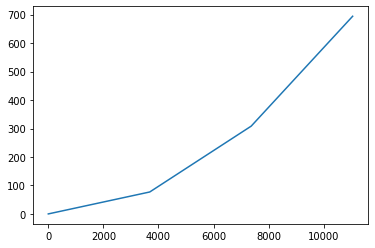

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
# #         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)

    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return (np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
# def tau_wave(z,wave_force):
# #     C=np.exp(z[-1])-np.exp(z[0])
# #     ans=[]
# #     for i in range(len(z)):
# #         ans.append([wave_force/C*(np.exp(z[i])-np.exp(z[0]))])
       
#     return np.array([0,0,wave_force]).T

In [138]:
# tau_wave(z0,wave_force)

In [139]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
kp,kd=1.95e4, 1.5e4
# kp,kd=1.95e-4, 1.5e-4
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [140]:
# x,y,z,φ,θ,ψ=η
# dx,dy,dz,dφ,dθ,dψ=dη

In [141]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [142]:
# Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

In [143]:
# def tau_t(x, dx, φ, θ, ψ, kp, kd,  x_ref = 0, dx_ref=0):
#     F=
#     Ret=Re_t_([φ,θ,ψ])  
#     return np.dot(Re_b(Ret), F)
    


In [144]:
# tau_t(x, dx, φ, θ, ψ, kp, kd)

In [145]:
Hs = 2.5 # significant wave height in m

In [146]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [147]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [148]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [149]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
#     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])).T*np.sin(2*np.pi/Tp*time+1)
#     print(F)
    Ret=Re_t_([φ,θ,ψ])
    
    return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [150]:
tau(η, dη, wave_coef, kp, kd,3)

array([ 4425.11907454, -2499.7415493 ,  5240.84730708,     0.        ,
           0.        ,     0.        ])

In [151]:
# η

In [152]:
# def tau(η, dη, wave_force, kp, kd,time,Tp=10, x_ref = 0, dx_ref=0):
#     x,y,z,φ,θ,ψ=η
#     dx,dy,dz,dφ,dθ,dψ=dη
# #     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
#     F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+np.array([0,0,wave_force])).T*np.sin(2*np.pi/Tp*time)
# #     print(F)
#     Ret=Re_t_([φ,θ,ψ])
    
#     return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [153]:
# tau(η, dη, wave_force, kp, kd,1)

In [154]:
# sampleTime = 1e-5                # sample time [seconds]
# N = int(2e5)                         # number of samples

In [155]:
# N

In [156]:
# vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [157]:
# [simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [158]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [159]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [160]:
# simData_1.shape

In [161]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
# simData=simData_1

In [162]:
# simData.shape

In [163]:
# ans_t = simTime_1

In [164]:
# simData[250]

In [165]:
# simData.shape

In [166]:
# ans_t=[]
# sum_=0
# for i in range(simData.shape[0]):
#     ans_t.append(sum_)
#     sum_+=sampleTime

In [167]:
# plotVehicleStates(simTime_1, simData_1, 1)                    
# plotControls(simTime_1, simData_1, vehicle_1, 2)

In [168]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [169]:
# numDataPoints = 5                 # number of 3D data points
# FPS = 10                            # frames per second (animated GIF)
# filename = '3D_animation.gif'       # data file for animated GIF
# browser = 'safari'                  # browser for visualization of animated GIF

In [170]:
# plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [171]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [172]:
# simData[1]

In [173]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [174]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [175]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [176]:
# diff=diff_1

In [177]:
V=VesselSemisub()

In [178]:
# thres =0.1

In [179]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [180]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [181]:
# simD = simD_1

In [182]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [183]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [184]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [185]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [186]:
# q0

In [187]:
# Jv(x, y, z )

In [188]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [189]:
# co=Time()

In [190]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [191]:
from scipy.integrate import solve_ivp

In [290]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     print(left.shape)
#     print(tau(η, dη, wave_force, 0, 0, t))


    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
#     print(η,dη)
#     print('M',V.M)
#     print('C000000',-left + tau(η,dη, wave_coef, kp, kd, t))
    hack =1
    ddη=np.linalg.lstsq(V.M*hack, -left + tau(η,dη, wave_coef, kp, kd, t)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη)
#     print(tau_force)
#     print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        + Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
#     ddx,ddy, ddz = 1/Ws*torch.linalg.lstsq(torch.from_numpy(Re_b(Ret).astype(np.float64)),torch.from_numpy(Z.astype(np.float64))).solution.cpu().numpy().T
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
   
#     A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
    A1111=np.concatenate([dx, ddx, 
                          np.zeros(node_N), np.zeros(node_N),
                          np.zeros(node_N), np.zeros(node_N),
                          np.zeros(node_N),  np.zeros(node_N),
                          np.zeros(node_N), np.zeros(node_N),
                          np.zeros(node_N),  np.zeros(node_N),
                          ], axis=0)
    
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [291]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [292]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [293]:
# q0.shape

In [294]:
# import numpy as np

In [295]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [296]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [297]:
# grayscott1d(4,q0)

In [298]:
# grayscott1d(4,q0).shape

In [299]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [300]:
import scipy

In [301]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [302]:
# tspan = (0., 60)
tspan = (0., 10)

In [303]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [ ]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              method='BDF'
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
6.357426880586747e-11
1.2714853761173495e-09
1.907228064176024e-09
5.085941504469398e-09
5.651046116077108e-09
6.357426880586747e-09
6.357426880586747e-09
1.907228064176024e-08
2.5429707522346987e-08
5.721684192528072e-08
6.286788804135783e-08
6.993169568645421e-08
6.993169568645421e-08
1.9708023329818915e-07
2.6065450210405664e-07
5.785258461333939e-07
6.35036307294165e-07
7.056743837451289e-07
7.056743837451289e-07
1.9771597598624783e-06
2.6129024479211527e-06
5.791615888214527e-06
6.3567204998222365e-06
7.063101264331876e-06
7.063101264331876e-06
1.977795502550537e-05
2.6135381906092118e-05
5.792251630902585e-05
6.357356242510296e-05
7.063737007019935e-05
7.063737007019935e-05
0.00016258904272339019
0.00020856487904998558
0.00043844406068296263
0.0004793114707510474
0.0005303957333361534
0.0005303957333361534
0.00013129705606258505
0.0001616268990587779
0.00031327611403974214
0.0003402359744808024
0.00037393580003212783
0.00037393580003212783
0.0004345954860245135
0.000464925329

0.06920143778546983
0.06993826862381887
0.0700692607728587
0.07023300095915849
0.07023300095915849
0.0705072909775441
0.0706444359867369
0.07133016103270094
0.071452067707539
0.07160445105108655
0.07160445105108655
0.07188854657387973
0.07203059433527631
0.07274083314225925
0.07286709781905622
0.07302492866505243
0.07302492866505243
0.07333888805628054
0.07349586775189458
0.07428076622996484
0.07442030373717733
0.07459472562119294
0.07459472562119294
0.07492372310317982
0.07508822184417326
0.07591071554914045
0.07605693665224572
0.07623971303112732
0.07623971303112732
0.07654809982142205
0.0767022932165694
0.07747326019230621
0.07761032098799277
0.07778164698260094
0.07778164698260094
0.07806004983006729
0.07819925125380045
0.0788952583724663
0.07901899297134024
0.07917366121993265
0.07917366121993265
0.07944761381973983
0.07958459011964342
0.08026947161916138
0.0803912283301868
0.08054342421896857
0.08054342421896857
0.08084329582545648
0.08099323162870042
0.0817429106449202
0.0818761

0.17262486013602868
0.1727965484305772
0.1727965484305772
0.17312218570570256
0.17328500434326527
0.1740990975310787
0.17424382520891218
0.17442473480620405
0.17442473480620405
0.17472907714176908
0.17488124830955162
0.17564210414846423
0.17577736740871536
0.17594644648402927
0.17594644648402927
0.17469723463853437
0.17483348455469952
0.1755147341355253
0.17563584517211656
0.17578723396785562
0.17578723396785562
0.17605973380018594
0.1761959837163511
0.17687723329717686
0.17699834433376813
0.1771497331295072
0.1771497331295072
0.1774542452309445
0.17760650128166316
0.17836778153525648
0.1785031202470064
0.1786722936366938
0.1786722936366938
0.17899953180657274
0.1791631508915122
0.17998124631620954
0.1801266855028224
0.1803084844860885
0.1803084844860885
0.1806183985319701
0.18077335555491092
0.18154814066961494
0.18168588024556231
0.18185805471549654
0.18185805471549654
0.18058327547172662
0.1807206709645457
0.181407648428641
0.18152977775559126
0.1816824394142791
0.1816824394142791
0

0.26118246511813875
0.26186264954513905
0.2619835712210502
0.2621347233159392
0.2621347233159392
0.26243487936433846
0.26258495738853804
0.2633353475095362
0.26346875019771365
0.26363550355793547
0.26363550355793547
0.26395462273880593
0.2641141823292411
0.2649119802814172
0.26505381102847075
0.2652310994622877
0.2652310994622877
0.26553452392189175
0.2656862361516938
0.26644479730070403
0.26657965261608363
0.2667482217603081
0.2667482217603081
0.265504074214775
0.26564056159101873
0.2663229984722371
0.2664443205844537
0.26659597322472445
0.26659597322472445
0.2668689479772118
0.2670054353534555
0.2676878722346739
0.2678091943468905
0.2679608469871612
0.2679608469871612
0.26826026943266496
0.2684099806554168
0.2691585367691761
0.2692916134116222
0.26945795921467985
0.26945795921467985
0.26977511662033593
0.269933695323164
0.27072658883730427
0.2708675476842625
0.27104374624296035
0.27104374624296035
0.27134613281826603
0.2714973261059189
0.2722532925441832
0.27238768657765233
0.2725556

0.35519214239929675
0.35586629607459397
0.35598614561686903
0.35613595754471283
0.35613595754471283
0.35643712841844655
0.3565877138553134
0.35734064103964763
0.35747449476130705
0.35764181191338135
0.35764181191338135
0.35795988215786023
0.3581189172800997
0.35891409289129694
0.35905545744439865
0.35923216313577583
0.35923216313577583
0.35952902767508255
0.35967745994473593
0.36041962129300276
0.3605515610882502
0.3607164858323095
0.3607164858323095
0.3594969930246922
0.3596294079691504
0.36029148269144134
0.360409184864293
0.3605563125803577
0.3605563125803577
0.36082114246927405
0.36095355741373225
0.3616156321360232
0.3617333343088749
0.36188046202493956
0.36188046202493956
0.3621773417122488
0.3623257815559034
0.3630679807741764
0.3631999273018694
0.36336486046148564
0.36336486046148564
0.36368454610614015
0.3638443889284674
0.36464360304010357
0.36478568554883894
0.3649632886847581
0.3649632886847581
0.3652655617787981
0.36541669832581813
0.36617238106091815
0.36630672465826924
0

0.43857676360972264
0.43887736366741303
0.4390276636962583
0.4397791638404843
0.4399127638661245
0.4400797638981747
0.4400797638981747
0.43883269865207314
0.4389606661732484
0.43960050377912474
0.43971425268683606
0.43985643882147524
0.43985643882147524
0.44011237386382573
0.440240341385001
0.44088017899087734
0.44099392789858866
0.44113611403322783
0.44113611403322783
0.4414363101836902
0.44158640825892137
0.4423368986350772
0.4424703191463938
0.44263709478553953
0.44263709478553953
0.44296271725761904
0.4431255284936588
0.44393958467385763
0.44408430577255964
0.44426520714593715
0.44426520714593715
0.44292666837077577
0.44307145516339386
0.4437953891264844
0.44392408849770054
0.44408496271172065
0.44408496271172065
0.4443745362969569
0.444519323089575
0.44524325705266554
0.44537195642388167
0.4455328306379018
0.4455328306379018
0.44581692463765943
0.4459589716375383
0.44666920663693244
0.44679547063682473
0.4469533006366901
0.4469533006366901
0.44722281257422336
0.44735756854299
0.44

0.5315170412548188
0.5315170412548188
0.5318293036142651
0.5319854347939882
0.5327660906926039
0.532904873963469
0.5330783530520502
0.5330783530520502
0.5317949262881493
0.5319338688048144
0.5326285813881405
0.5327520858473985
0.532906466421471
0.532906466421471
0.5331843514548015
0.5333232939714666
0.5340180065547927
0.5341415110140507
0.5342958915881232
0.5342958915881232
0.53458095148486
0.5347234814332282
0.53543613117507
0.5355628244625087
0.5357211910718068
0.5357211910718068
0.5360022256541621
0.5361427429453398
0.536845329401228
0.5369702336600526
0.5371263639835833
0.5371263639835833
0.5373954112163442
0.5375299348327247
0.538202552914627
0.5383221294625208
0.5384716001473879
0.5384716001473879
0.5387353995345403
0.5388672992281165
0.5395267976959974
0.5396440418680651
0.5397905970831498
0.5397905970831498
0.540064088997294
0.5402008349543661
0.5408845647397266
0.5410061167015684
0.5411580566538707
0.5411580566538707
0.5414463914676922
0.5415905588746031
0.542311395909157
0.54

0.6209767668101612
0.6211068411017244
0.6212694339661785
0.6212694339661785
0.6200582593174097
0.6201843398830684
0.6208147427113619
0.6209268143252809
0.6210669038426794
0.6210669038426794
0.6213190649739968
0.6214451455396555
0.6220755483679491
0.622187619981868
0.6223277094992665
0.6223277094992665
0.6226221922745848
0.6227694336622439
0.6235056406005396
0.6236365218340144
0.6238001233758579
0.6238001233758579
0.6241196052149927
0.62427934613456
0.6250780507323971
0.6252200426609014
0.6253975325715319
0.6253975325715319
0.6240856932201362
0.6242284781422752
0.6249424027529709
0.6250693226837613
0.6252279725972492
0.6252279725972492
0.6255135424415275
0.6256563273636665
0.6263702519743621
0.6264971719051525
0.6266558218186404
0.6266558218186404
0.6269349813685772
0.6270745611435455
0.6277724600183873
0.6278965309294703
0.628051619568324
0.628051619568324
0.6283160435480305
0.6284482555378837
0.6291093154871501
0.6292268372559086
0.6293737394668566
0.6293737394668566
0.629633407894391

0.7125087389558412
0.7126372473683322
0.712797882883946
0.712797882883946
0.7131066528195461
0.7132610377873463
0.7140329626263467
0.7141701937088357
0.7143417325619469
0.7143417325619469
0.7146235504269272
0.7147644593594172
0.7154690040218679
0.7155942564063036
0.7157508218868481
0.7157508218868481
0.7145806459457184
0.7147001026376041
0.7152973860970328
0.7154035698231535
0.7155362994808042
0.7155362994808042
0.7157752128645757
0.7158946695564614
0.7164919530158901
0.7165981367420108
0.7167308663996615
0.7167308663996615
0.7170286885208734
0.7171775995814794
0.7179221548845093
0.7180545202717146
0.7182199770057212
0.7182199770057212
0.7185581548099773
0.7187272437121054
0.7195726882227459
0.719722989469082
0.719910866027002
0.719910866027002
0.7185132431918454
0.7186598762849076
0.7193930417502183
0.7195233822773847
0.7196863079363426
0.7196863079363426
0.7199795741224668
0.720126207215529
0.7208593726808398
0.7209897132080061
0.721152638866964
0.721152638866964
0.7214296215183518
0

0.8013281755140972
0.8016236677777493
0.8017714139095753
0.8025101445687054
0.802641474463662
0.8028056368323575
0.8028056368323575
0.8031313148965565
0.8032941539286561
0.8041083490891537
0.8042530948954644
0.8044340271533528
0.8044340271533528
0.8030912231567796
0.8032340163189906
0.8039479821300459
0.8040749093853446
0.804233568454468
0.804233568454468
0.8045191547788901
0.8046619479411012
0.8053759137521564
0.8055028410074552
0.8056615000765786
0.8056615000765786
0.805939116276824
0.8060779243769468
0.8067719648775605
0.8068953498554474
0.807049581077806
0.807049581077806
0.8073096492007734
0.807439683262257
0.8080898535696754
0.8082054394021054
0.8083499216926429
0.8083499216926429
0.8086047172001137
0.8087321149538492
0.8093691037225266
0.8094823461702914
0.8096238992299974
0.8096238992299974
0.8098948455771273
0.8100303187506923
0.810707684618517
0.8108281052172415
0.8109786309656469
0.8109786309656469
0.8112704216012596
0.811416316919066
0.8121457935080977
0.8122754782350367
0.

0.8939396924338929
0.8939396924338929
0.8941800646942788
0.8943002508244717
0.8949011814754365
0.8950080135911636
0.8951415537358224
0.8951415537358224
0.8954343166821243
0.8955806981552751
0.8963126055210296
0.8964427223860527
0.8966053684673315
0.8966053684673315
0.89693499365721
0.8970998062521491
0.8979238692268451
0.8980703693112355
0.8982534944167235
0.8982534944167235
0.8968964377316331
0.8970419723637839
0.8977696455245379
0.8978990096420052
0.8980607147888394
0.8980607147888394
0.898351784053141
0.8984973186852918
0.8992249918460458
0.8993543559635131
0.8995160611103473
0.8995160611103473
0.899790262690419
0.8999273634804547
0.9006128674306336
0.9007347347995543
0.9008870690107053
0.9008870690107053
0.9011374665765315
0.9012626653594445
0.90188865927401
0.9019999470810439
0.9021390568398362
0.9021390568398362
0.9023889109732286
0.9025138380399249
0.903138473373406
0.9032495196549137
0.9033883275067984
0.9033883275067984
0.9036659270341866
0.9038047267978806
0.9044987256163508


0.9821216806861097
0.9822452506817704
0.9823997131763463
0.9823997131763463
0.9812541885947211
0.9813765075295001
0.981988102203395
0.9820968301454208
0.982232740072953
0.982232740072953
0.982477377942511
0.98259969687729
0.9832112915511849
0.9833200194932107
0.9834559294207429
0.9834559294207429
0.9837467770048755
0.9838922007969417
0.9846193197572732
0.984748585350221
0.9849101673414058
0.9849101673414058
0.9852322681118558
0.9853933184970808
0.9861985704232057
0.9863417263211836
0.9865206711936557
0.9865206711936557
0.9851978704260155
0.9853417219683203
0.9860609796798443
0.9861888477174486
0.986348682764454
0.986348682764454
0.9866363858490637
0.9867802373913684
0.9874994951028925
0.9876273631404968
0.9877871981875022
0.9877871981875022
0.9880615727759477
0.9881987600701706
0.9888846965412846
0.989006640802816
0.9891590711297302
0.9891590711297302
0.9894133396008985
0.9895404738364826
0.9901761450144033
0.9902891532238114
0.9904304134855716
0.9904304134855716
0.9906833264478059
0.9

1.0678061992825885
1.0678061992825885
1.06809803921372
1.0682439591792858
1.0689735590071148
1.0691032656431732
1.0692653989382463
1.0692653989382463
1.0695690512882134
1.069720877463197
1.070480008338115
1.0706149649381003
1.070783660688082
1.070783660688082
1.069538332899335
1.0696747998798795
1.0703571347826015
1.0704784387653077
1.0706300687436903
1.0706300687436903
1.070903002704779
1.0710394696853234
1.0717218045880454
1.0718431085707516
1.0719947385491342
1.0719947385491342
1.0722745215646179
1.0724144130723596
1.073113870611069
1.0732382186179505
1.0733936536265527
1.0733936536265527
1.0736702524243504
1.0738085518232494
1.074500048817744
1.0746229816167652
1.0747766476155418
1.0747766476155418
1.0750423789134598
1.075175244562419
1.075839572807214
1.0759576756062887
1.076105304105132
1.076105304105132
1.0763657782876435
1.0764960153788992
1.0771472008351777
1.077262967138516
1.077407675017689
1.077407675017689
1.0776765865691984
1.0778110423449532
1.0784833212237268
1.07860283

1.160944094875287
1.1617108753480505
1.1618471918765418
1.162017587537156
1.162017587537156
1.1623118659944676
1.1624590052231236
1.163194701366403
1.1633254917918747
1.1634889798237147
1.1634889798237147
1.1622676741369293
1.162392717436816
1.1630179339362494
1.1631290835361487
1.1632680205360229
1.1632680205360229
1.1635181071357963
1.163643150435683
1.1642683669351164
1.1643795165350157
1.1645184535348898
1.1645184535348898
1.1648124605645926
1.1649594640794443
1.1656944816537016
1.1658251514446807
1.1659884886834044
1.1659884886834044
1.1663078466435561
1.1664675256236319
1.1672659205240108
1.1674078573951894
1.1675852784841625
1.1675852784841625
1.1662721011330361
1.166413907357852
1.1671229384819317
1.1672489884595458
1.1674065509315634
1.1674065509315634
1.1676901633811951
1.167831969606011
1.1685410007300907
1.1686670507077048
1.1688246131797224
1.1688246131797224
1.1691027760805548
1.169241857530971
1.169937264783052
1.1700608927389775
1.1702154276838843
1.1702154276838843
1.1

1.2470279923429288
1.247768020252772
1.2478995807700772
1.248064031416709
1.248064031416709
1.2483600425806463
1.248508048162615
1.249248076072458
1.2493796365897634
1.2495440872363952
1.2495440872363952
1.2498236396389166
1.2499634158401776
1.2506622968464813
1.250786542358713
1.2509418492490028
1.2509418492490028
1.2511941240091202
1.2513202613891787
1.2519509482894722
1.25206307040508
1.2522032230495896
1.2522032230495896
1.25245166172864
1.2525758810681653
1.2531969777657916
1.2533073949564808
1.253445416444842
1.253445416444842
1.2537225533867467
1.2538611218576992
1.2545539642124608
1.2546771361866405
1.2548311011543654
1.2548311011543654
1.2551392705798687
1.2552933552926204
1.256063778856379
1.2562007430454918
1.2563719482818825
1.2563719482818825
1.256669652051106
1.256818503935718
1.2575627633587771
1.2576950761450987
1.2578604671280007
1.2578604671280007
1.256624801081174
1.25675122748082
1.257383359479049
1.2574957385009562
1.2576362122783404
1.2576362122783404
1.2578890650

1.3346441133829015
1.3348867786477132
1.335008111280119
1.3356147744421485
1.3357226256709538
1.3358574397069602
1.3358574397069602
1.336155267528493
1.336304181439259
1.3370487509930906
1.337181118913772
1.3373465788146233
1.3373465788146233
1.337683390062612
1.3378517956866065
1.3386938238065784
1.3388435176945734
1.339030635054567
1.339030635054567
1.3376427702253084
1.337790865930651
1.3385313444573639
1.338662985084335
1.338827535868049
1.338827535868049
1.3391237272787342
1.3392718229840768
1.3400123015107896
1.3401439421377608
1.3403084929214748
1.3403084929214748
1.3405868693081182
1.3407260575014401
1.3414219984680489
1.341545721306557
1.3417003748546923
1.3417003748546923
1.3419537645712332
1.3420804594295037
1.3427139337208562
1.342826551372652
1.342967323437397
1.342967323437397
1.3432202621649167
1.3433467315286767
1.343979078347476
1.344091495559707
1.3442320170749957
1.3442320170749957
1.344514212121843
1.3446553096452667
1.345360797262385
1.345486217283206
1.34564299230

1.4289162626964245
1.4289162626964245
1.4291999045756745
1.4293417255152996
1.430050830213425
1.4301768932708694
1.430334472092675
1.430334472092675
1.4291652256572602
1.429289707137678
1.4299121145397673
1.4300227647445831
1.430161077500603
1.430161077500603
1.4304100404614388
1.4305345219418566
1.431156929343946
1.4312675795487617
1.4314058923047817
1.4314058923047817
1.4317041601820069
1.4318532941206192
1.432598963813682
1.432731527314671
1.4328972316909072
1.4328972316909072
1.4332293448391267
1.4333954014132364
1.434225684283785
1.4343732901274382
1.4345577974320045
1.4345577974320045
1.4331929004516788
1.4333407348320644
1.434079906733993
1.4342113150721139
1.4343755754947647
1.4343755754947647
1.4346712442555363
1.4348190786359218
1.4355582505378506
1.4356896588759713
1.4358539192986222
1.4358539192986222
1.4361347122680257
1.4362751087527275
1.4369770911762365
1.437101888051527
1.43725788414564
1.43725788414564
1.4375169193138555
1.4376464368979631
1.4382940248185014
1.4384091

1.5208766734207364
1.5210164578138368
1.5211911883052123
1.5211911883052123
1.519900143311349
1.520040908025607
1.5207447315968976
1.5208698557873495
1.521026261025414
1.521026261025414
1.5213077904539303
1.5214485551681882
1.5221523787394788
1.5222775029299307
1.5224339081679952
1.5224339081679952
1.5227231688914158
1.5228677992531263
1.523590951061678
1.5237195113831983
1.5238802117850987
1.5238802117850987
1.5241664291467814
1.5243095378276226
1.5250250812318293
1.5251522889481328
1.525311298593512
1.525311298593512
1.525585756080254
1.525722984823625
1.52640912854048
1.5265311096456986
1.5266835860272219
1.5266835860272219
1.5269519339585729
1.5270861079242486
1.5277569777526263
1.5278762434998934
1.5280253256839773
1.5280253256839773
1.528302478554164
1.5284410549892573
1.5291339371647241
1.5292571162181403
1.5294110900349107
1.5294110900349107
1.5297034461565449
1.5298496242173618
1.5305805145214473
1.530710450575507
1.5308728706430814
1.5308728706430814
1.5311674164119815
1.5313

1.611331169184801
1.611475520530376
1.611475520530376
1.6117329063934014
1.6118615993249141
1.6125050639824778
1.612619457699378
1.6127624498455033
1.6127624498455033
1.6130516138110174
1.6131961957937744
1.6139191057075593
1.6140476230255656
1.6142082696730733
1.6142082696730733
1.6145296381695087
1.6146903224177265
1.615493743658815
1.6156365741016752
1.6158151121552504
1.6158151121552504
1.6161229404493296
1.6162768545963693
1.617046425331567
1.6171832379067133
1.6173542536256462
1.6173542536256462
1.6160747016244847
1.6162044963591018
1.6168534700321873
1.6169688431296247
1.6171130595014216
1.6171130595014216
1.617372648970656
1.617502443705273
1.6181514173783584
1.618266790475796
1.6184110068475928
1.6184110068475928
1.618718452217359
1.6188721749022421
1.6196407883266575
1.6197774307132202
1.6199482336964237
1.6199482336964237
1.620283416529377
1.6204510079458534
1.6212889650282365
1.6214379351762156
1.6216241478611897
1.6216241478611897
1.620244467523183
1.6203925844365628
1.621

1.7089303301514918
1.7089303301514918
1.7077242635528318
1.7078564695163998
1.7085174993342398
1.7086350157463002
1.7087819112613758
1.7087819112613758
1.7090463231885118
1.7091785291520798
1.7098395589699198
1.7099570753819802
1.7101039708970558
1.7101039708970558
1.710409173637775
1.7105617750081343
1.7113247818599322
1.711460427522474
1.7116299846006513
1.7116299846006513
1.711962567235995
1.7121288585536667
1.7129603151420258
1.713108129646623
1.7132928977773696
1.7132928977773696
1.7135958636710582
1.7137473466179023
1.7145047613521236
1.7146394128604296
1.7148077272458122
1.7148077272458122
1.7135426975776336
1.7136675974777655
1.7142920969784257
1.7144031191118763
1.7145418967786896
1.7145418967786896
1.7147916965789536
1.7149165964790856
1.7155410959797457
1.7156521181131963
1.7157908957800097
1.7157908957800097
1.7161089839311268
1.7162680280066853
1.7170632483844783
1.7172046208960858
1.7173813365355954
1.7173813365355954
1.7177454481390355
1.7179275039407556
1.71883778294935

1.7959948416288676
1.796291231343449
1.7964394262007397
1.7971804004871934
1.7973121292492296
1.7974767902017748
1.7974767902017748
1.7978050432434973
1.7979691697643585
1.7987898023686646
1.7989356926094302
1.7991180554103872
1.7991180554103872
1.7994350659887637
1.7995935712779518
1.8003860977238932
1.8005269913142827
1.8007031083022698
1.8007031083022698
1.7993887697321767
1.7995241268930715
1.8002009126975456
1.8003212301738964
1.800471627019335
1.800471627019335
1.8007423413411245
1.8008776985020194
1.8015544843064935
1.8016748017828443
1.801825198628283
1.801825198628283
1.8021398460745652
1.8022971697977064
1.8030837884134119
1.8032236317228707
1.8033984358596942
1.8033984358596942
1.8037378200328216
1.8039075121193855
1.8047559725522042
1.804906809962483
1.8050953567253316
1.8050953567253316
1.8037020429312554
1.803853846467036
1.8046128641459387
1.8047478006221882
1.8049164712174999
1.8049164712174999
1.805220078289061
1.8053718818248417
1.8061308995037444
1.806265835979994
1.

In [ ]:
# co.my_time

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
# !pip3 install diffeqpy

In [ ]:
# node_N

In [ ]:
# t

In [ ]:
# plt.plot(us.t,us.u)
# plt.show()

In [ ]:
# node_N

In [ ]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [ ]:
# fin

In [ ]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [ ]:
fin.y.T[0]

In [ ]:
len(fin.y.T)

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin.y.T[j,[i for i in range(0,node_N)]]
Y=fin.y.T[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[j,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
    # ax.set_xlim([0, 5])
    # ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.y

In [ ]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)